In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np


import random
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.preprocessing as preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import register_keras_serializable

from Code.utils.dataset import Dataset
import Code.utils.store_model as store_model

In [2]:
#set seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
@register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=self.num_heads, key_dim=self.embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(self.dense_dim, activation="relu"),
            layers.Dense(self.embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        super().build(input_shape)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


In [4]:
@register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def build(self, input_shape):
        self.token_embeddings = layers.Embedding(
            input_dim=self.input_dim, output_dim=self.output_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=self.sequence_length, output_dim=self.output_dim
        )
        super().build(input_shape)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


In [5]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/dataset1_inputs.csv',
                  '../../Dataset/dataset1_outputs.csv')

X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_datasets_unprocessed('Text', 'Label', sep='\t', rem_punctuation=True)

In [6]:
#tokenization
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)  # limit to top max_words words
tokenizer.fit_on_texts(X_train.iloc[:, 0])

X_train = tokenizer.texts_to_sequences(X_train.iloc[:, 0])
X_validation = tokenizer.texts_to_sequences(X_validation.iloc[:, 0])
X_test = tokenizer.texts_to_sequences(X_test.iloc[:, 0])

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_validation = preprocessing.sequence.pad_sequences(X_validation, maxlen=max_len)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [7]:
embed_dim = 128
num_heads = 8
dense_dim = 64

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(max_len, max_words, embed_dim)(inputs)

for _ in range(1):
    x = TransformerEncoder(
        embed_dim,
        dense_dim,
        num_heads,
    )(x)

x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.8)(x)



outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
              loss="binary_crossentropy",
              metrics=["acc"])
model.summary()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-6
)

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    reduce_lr
]

history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs=10, callbacks=callbacks)
model = keras.models.load_model("full_transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalEmbedding": PositionalEmbedding})

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, None, 128)      │       665,600 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, None, 128)      │       544,576 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, None, 128)      │       544,576 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,754,881 (6.69 MB)

 Trainable params: 1,754,881 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 842ms/step - acc: 0.4947 - loss: 1.3064 - val_acc: 0.5130 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 840ms/step - acc: 0.5902 - loss: 0.6576 - val_acc: 0.9750 - val_loss: 0.0855 - learning_rate: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 846ms/step - acc: 0.9796 - loss: 0.0783 - val_acc: 0.9960 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 839ms/step - acc: 0.9980 - loss: 0.0141 - val_acc: 0.9960 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 849ms/step - acc: 0.9961 - loss: 0.0130 - val_acc: 0.9970 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 79s 837ms/step - acc: 1.0000 - loss: 5.4111e-04 - val_acc: 0.9970 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 867ms/step - acc: 1.0000 - loss: 3.7414e-04 - val_acc: 0.9970 - val_loss: 0.0144 - learning_rate

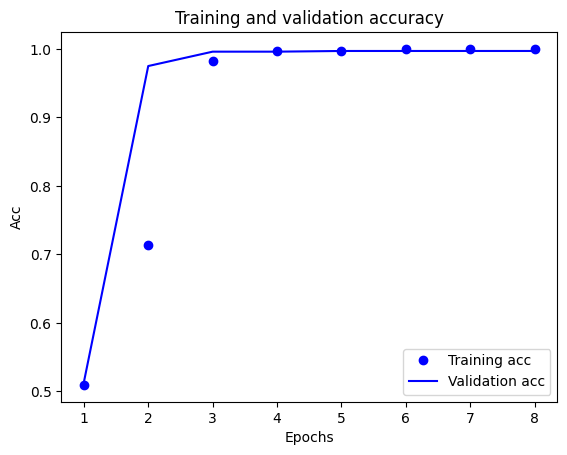

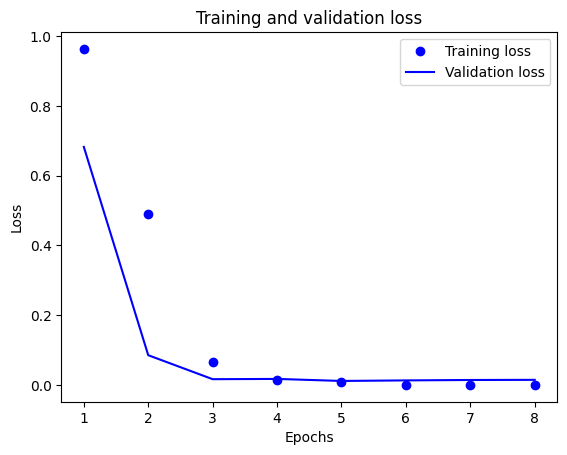

In [8]:
# Plot curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Predict output

output = model.predict(X_test)

if y_test is not None:
    # Evaluate Model

    print(model.evaluate(X_test, y_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - acc: 0.6961 - loss: 1.7209
[1.7091923952102661, 0.6846153736114502]


In [10]:
# Store output

results_filepath = './Results/transformer_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, output)
results.to_csv(results_filepath, sep='\t', index=False)

In [11]:
# Store network model

model_filepath = './Model/transformer'
model_key = 'transformer'

store_model.store_model(model_filepath, model_key, model)

In [12]:
# Retrieve network model

model_filepath = './Model/transformer'
model_key = 'transformer'

model = store_model.retrieve_model(model_filepath, model_key)

In [13]:
dataset.set_dataset_test('../../Dataset/dataset1_inputs.csv', '../../Dataset/dataset1_outputs.csv')

X_test, y_test, ids = dataset.get_test_dataset_unprocessed('Text', 'Label', sep='\t', rem_punctuation=False)

X_test = tokenizer.texts_to_sequences(X_test.iloc[:, 0])
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [14]:
print("Loss")
history_dict['loss']

Loss


[0.9630217552185059,
 0.49007484316825867,
 0.06640900671482086,
 0.014852537773549557,
 0.009628132916986942,
 0.0005013651680201292,
 0.00032298211590386927,
 0.0002874621713999659]

In [15]:
print("Val Loss")
history_dict['val_loss']

Val Loss


[0.6823076009750366,
 0.08545572310686111,
 0.016710298135876656,
 0.01746692694723606,
 0.011658759787678719,
 0.01326717622578144,
 0.014425773173570633,
 0.014831297099590302]

In [16]:
print("Accuracy")
history_dict['acc']

Accuracy


[0.5093333125114441,
 0.7133333086967468,
 0.9826666712760925,
 0.9976666569709778,
 0.9976666569709778,
 1.0,
 1.0,
 1.0]

In [17]:
print("Val Accuracy")
history_dict['val_acc']

Val Accuracy


[0.5130000114440918,
 0.9750000238418579,
 0.9959999918937683,
 0.9959999918937683,
 0.996999979019165,
 0.996999979019165,
 0.996999979019165,
 0.996999979019165]